In [1]:
from PIL import Image
import numpy as np
from scipy.io import loadmat
import tqdm
import pandas as pd
import os
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from glob import glob

# Image segmentation

Results from pretrained model (https://github.com/CSAILVision/semantic-segmentation-pytorch) on streetview data, 

Model inference used ade20k-resent50dilated-ppm_deepsup.yaml config

In [3]:
#!/opt/anaconda3/envs/straatvinken-dl/bin/pip install --upgrade pandas==1.3.5

In [5]:
### UTILITY FUNCTIONS

import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('../data/external/CSAILVision/color150.mat')['colors']
names = {}
with open('../data/external/CSAILVision/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis))
    
def create_mask_and_masked(img, pred, mask_path, masked_path):
    # create mask
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)
    pred_img=PIL.Image.fromarray(pred_color)
    pred_img.save(mask_path)
    PIL.Image.blend(pred_img, PIL.Image.fromarray(img), 0.5).save(masked_path)
    

# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
    
## LOAD MODEL
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='../data/model/CSAILVisionSegmentation/ade20k-resnet50dilated-ppm_deepsup/ckpt/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='../data/model/CSAILVisionSegmentation/ade20k-resnet50dilated-ppm_deepsup/ckpt/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
# when using a GPU
#segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [8]:
len(all_images)

['../data/raw/google_streetview/8jvSVVfPx0SQVPwCXwmKJA_2_S_180.jpg',
 '../data/raw/google_streetview/g-90hwq4uLjljj4CNXOJFQ_2_S_180.jpg',
 '../data/raw/google_streetview/csph1njSXkcTN-5BVHzezQ_0_N_0.jpg',
 '../data/raw/google_streetview/dR4B7eW0LV4oJ_yPf0u5jg_3_W_270.jpg',
 '../data/raw/google_streetview/BkW4E-RLefbYegX3FoZndA_3_W_270.jpg',
 '../data/raw/google_streetview/MzckrU259Pfbj9MmBRKpKQ_3_W_270.jpg',
 '../data/raw/google_streetview/-N9R4xAKPIouKdDqy5PvTQ_1_E_90.jpg',
 '../data/raw/google_streetview/kfJ7i9kYu6OcmzP01KwC-Q_0_N_0.jpg',
 '../data/raw/google_streetview/8x8lv0XlrjQQLB7K1lRD0w_0_N_0.jpg',
 '../data/raw/google_streetview/JqO2PNHO1SpY6WuotK80pQ_3_W_270.jpg',
 '../data/raw/google_streetview/n-kxWmB7qdN_KYtT6n02WA_1_E_90.jpg',
 '../data/raw/google_streetview/rxNttjQqg9z9FXcMx3Akhg_0_N_0.jpg',
 '../data/raw/google_streetview/ooZXh_FkqkkfDapKaaaVrA_0_N_0.jpg',
 '../data/raw/google_streetview/LU0z4dUV2w2rgiD74m37Zg_1_E_90.jpg',
 '../data/raw/google_streetview/iBk9RCTKlfglMvB

In [9]:
# enable continue for this long operation
import pickle

segmentation_data = pickle.load(open("segm_bck.pkl", "rb"))
len(segmentation_data)

[{'img': '8jvSVVfPx0SQVPwCXwmKJA_2_S_180.jpg',
  'img_full': '../data/raw/google_streetview/8jvSVVfPx0SQVPwCXwmKJA_2_S_180.jpg',
  'segmentation_data': {'wall': 3.9868164062,
   'building': 19.9047851562,
   'sky': 29.8552246094,
   'floor': 0.0,
   'tree': 12.7145996094,
   'ceiling': 0.0,
   'road': 3.458984375,
   'bed': 0.0,
   'windowpane': 0.0,
   'grass': 0.2067871094,
   'cabinet': 0.0,
   'sidewalk': 17.8793945312,
   'person': 0.0,
   'earth': 3.5441894531,
   'door': 0.0,
   'table': 0.0,
   'mountain': 0.0,
   'plant': 4.1032714844,
   'curtain': 0.0,
   'chair': 0.0,
   'car': 0.3171386719,
   'water': 3.9968261719,
   'painting': 0.0,
   'sofa': 0.0,
   'shelf': 0.0,
   'house': 0.0112304688,
   'sea': 0.0,
   'mirror': 0.0,
   'rug': 0.0,
   'field': 0.0,
   'armchair': 0.0,
   'seat': 0.0,
   'fence': 0.0,
   'desk': 0.0,
   'rock': 0.0,
   'wardrobe': 0.0,
   'lamp': 0.0,
   'bathtub': 0.0,
   'railing': 0.0,
   'cushion': 0.0,
   'base': 0.0,
   'box': 0.0,
   'column

In [12]:
# Run the segmentation at the highest resolution.
import pickle
from glob import glob

def process_single_image(_img):
    pil_image = PIL.Image.open(_img).convert('RGB')
    img_original = numpy.array(pil_image)
    img_data = pil_to_tensor(pil_image)
    singleton_batch = {'img_data': img_data[None]} #.cuda()
    output_size = img_data.shape[1:]
    scores = segmentation_module(singleton_batch, segSize=output_size)

    
    # Get the predicted scores for each pixel
    _, pred = torch.max(scores, dim=1)
    pred = pred.cpu()[0].numpy()
    
    percentages = (numpy.bincount(pred.flatten()) * 100)/numpy.bincount(pred.flatten()).sum()
    result_dict = {names[i+1]: percentages[i] for i in range(len(percentages))}
    
    mask_path = _img.replace("/raw/google_streetview/","/processed/google_streetview_mask/")
    masked_path = _img.replace("/raw/google_streetview/","/processed/google_streetview_masked/")
    
    create_mask_and_masked(img_original, pred, mask_path, masked_path)
    return result_dict

all_images = glob("../data/raw/google_streetview/*.jpg")
processed_images = [item["img_full"] for item in segmentation_data]
print(f"{len(processed_images)}/{len(all_images)} were previously processed")

with torch.no_grad():
    i=1
    for _img in tqdm(all_images):
        if _img in processed_images:
            continue
        _res = process_single_image(_img)
        segmentation_data.append({"img": os.path.basename(_img), "img_full": _img,"segmentation_data": _res})
        if i % 10 == 0:
            print("saving after number of iterations")
            pickle.dump(segmentation_data, open("segm.pkl", "wb"))
        i+=1


6420/14148 were previously processed


  0%|          | 0/14148 [00:00<?, ?it/s]

saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations
saving after number of iterations



KeyboardInterrupt



In [36]:
len(segmentation_data)

6420

In [37]:
pickle.dump(segmentation_data, open("segm_bck.pkl", "wb"))

In [10]:
segmentation_data = pickle.load(open("segm.pkl", "rb"))
len(segmentation_data)

14148

In [12]:
import pandas as pd
segm_df = pd.DataFrame(segmentation_data)
segm_df

,img,img_full,segmentation_data
0,--QkJckaqobMhxpzoXUsMg_0_N_0.jpg,../data/raw/google_streetview/--QkJckaqobMhxpz...,"{'wall': 0.0, 'building': 62.846435546875, 'sk..."
1,--QkJckaqobMhxpzoXUsMg_1_E_90.jpg,../data/raw/google_streetview/--QkJckaqobMhxpz...,"{'wall': 0.110595703125, 'building': 38.410400..."
2,--QkJckaqobMhxpzoXUsMg_2_S_180.jpg,../data/raw/google_streetview/--QkJckaqobMhxpz...,"{'wall': 14.39404296875, 'building': 1.6340332..."
3,--QkJckaqobMhxpzoXUsMg_3_W_270.jpg,../data/raw/google_streetview/--QkJckaqobMhxpz...,"{'wall': 2.97705078125, 'building': 5.20581054..."
4,--RMkDzVN_XEAJSzRt9ZOA_0_N_0.jpg,../data/raw/google_streetview/--RMkDzVN_XEAJSz...,"{'wall': 0.0, 'building': 2.644287109375, 'sky..."
...,...,...,...
14143,zxbFN4N6IBfzq3qVFIzkSA_3_W_270.jpg,../data/raw/google_streetview/zxbFN4N6IBfzq3qV...,"{'wall': 0.0, 'building': 0.0, 'sky': 0.583740..."
14144,zzFWrWYXy9YWqEqjPtGtbw_0_N_0.jpg,../data/raw/google_streetview/zzFWrWYXy9YWqEqj...,"{'wall': 0.0, 'building': 69.44970703125, 'sky..."
14145,zzFWrWYXy9YWqEqjPtGtbw_1_E_90.jpg,../data/raw/google_streetview/zzFWrWYXy9YWqEqj...,"{'wall': 0.0, 'building': 95.3720703125, 'sky'..."
14146,zzFWrWYXy9YWqEqjPtGtbw_2_S_180.jpg,../data/raw/google_streetview/zzFWrWYXy9YWqEqj...,"{'wall': 0.0, 'building': 74.572265625, 'sky':..."


In [15]:
pickle.dump(
    segm_df, 
        open(
            "../data/processed/20220222_streetview_segmentation_results_14148_images_flanders_df.pkl", 
            "wb"
        )
   )

In [13]:
import pickle
location_df = pickle.load(open("../data/processed/20220222_streetview_location_panorama_df.pkl", "rb"))
location_df.head()

,i,coord,location,status,metadata,pano_id,date,duplicate
0,0,"50.940104,4.062487","{'lat': 50.94009849499412, 'lng': 4.0624448891...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",OlhTCaEsakPsBnnrQ33b1Q,2019-05,False
1,1,"50.944063,4.028181","{'lat': 50.94009849499412, 'lng': 4.0624448891...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",OlhTCaEsakPsBnnrQ33b1Q,2019-05,False
2,2,"51.084607,3.436877","{'lat': 51.08462265868495, 'lng': 3.4368991355...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",JNVwpgpEKp5AZIYKxZm9ew,2019-05,False
3,3,"51.087108,3.458313","{'lat': 51.08462265868495, 'lng': 3.4368991355...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",JNVwpgpEKp5AZIYKxZm9ew,2019-05,False
4,4,"50.983138,4.828583","{'lat': 50.9831431950842, 'lng': 4.82860213679...",ok,"{'copyright': '© Google', 'date': '2021-03', '...",TFSmQVL_3EteK0mI2BNVdw,2021-03,False


In [14]:
segmentation_images_df = segm_df 

In [15]:
prefix = "../data/raw/google_streetview/"
suffixes = [
    "_0_N_0.jpg", 
    "_1_E_90.jpg", 
    "_2_S_180.jpg", 
    "_3_W_270.jpg",
]

orientations = [
    "north", 
    "east", 
    "south", 
    "west"
]

def get_pano_id(image_name):
    image_name = image_name.replace(prefix, "")
    for suffix in suffixes:
        image_name = image_name.replace(suffix, "")
    return image_name

def get_orientation(image_name):
    return orientations[int(np.where([suffix in image_name for suffix in suffixes])[0])]

#for image in os.listdir("../data/raw/google_streetview")[:300]:
#    print(image, get_orientation(image))

segmentation_images_df["pano_id"] = segmentation_images_df.img_full.apply(lambda x: get_pano_id(x))
segmentation_images_df["orientation"] = segmentation_images_df.img_full.apply(lambda x: get_orientation(x))
segmentation_images_df

,img,img_full,segmentation_data,pano_id,orientation
0,--QkJckaqobMhxpzoXUsMg_0_N_0.jpg,../data/raw/google_streetview/--QkJckaqobMhxpz...,"{'wall': 0.0, 'building': 62.846435546875, 'sk...",--QkJckaqobMhxpzoXUsMg,north
1,--QkJckaqobMhxpzoXUsMg_1_E_90.jpg,../data/raw/google_streetview/--QkJckaqobMhxpz...,"{'wall': 0.110595703125, 'building': 38.410400...",--QkJckaqobMhxpzoXUsMg,east
2,--QkJckaqobMhxpzoXUsMg_2_S_180.jpg,../data/raw/google_streetview/--QkJckaqobMhxpz...,"{'wall': 14.39404296875, 'building': 1.6340332...",--QkJckaqobMhxpzoXUsMg,south
3,--QkJckaqobMhxpzoXUsMg_3_W_270.jpg,../data/raw/google_streetview/--QkJckaqobMhxpz...,"{'wall': 2.97705078125, 'building': 5.20581054...",--QkJckaqobMhxpzoXUsMg,west
4,--RMkDzVN_XEAJSzRt9ZOA_0_N_0.jpg,../data/raw/google_streetview/--RMkDzVN_XEAJSz...,"{'wall': 0.0, 'building': 2.644287109375, 'sky...",--RMkDzVN_XEAJSzRt9ZOA,north
...,...,...,...,...,...
14143,zxbFN4N6IBfzq3qVFIzkSA_3_W_270.jpg,../data/raw/google_streetview/zxbFN4N6IBfzq3qV...,"{'wall': 0.0, 'building': 0.0, 'sky': 0.583740...",zxbFN4N6IBfzq3qVFIzkSA,west
14144,zzFWrWYXy9YWqEqjPtGtbw_0_N_0.jpg,../data/raw/google_streetview/zzFWrWYXy9YWqEqj...,"{'wall': 0.0, 'building': 69.44970703125, 'sky...",zzFWrWYXy9YWqEqjPtGtbw,north
14145,zzFWrWYXy9YWqEqjPtGtbw_1_E_90.jpg,../data/raw/google_streetview/zzFWrWYXy9YWqEqj...,"{'wall': 0.0, 'building': 95.3720703125, 'sky'...",zzFWrWYXy9YWqEqjPtGtbw,east
14146,zzFWrWYXy9YWqEqjPtGtbw_2_S_180.jpg,../data/raw/google_streetview/zzFWrWYXy9YWqEqj...,"{'wall': 0.0, 'building': 74.572265625, 'sky':...",zzFWrWYXy9YWqEqjPtGtbw,south


In [16]:
labels_pivoted_df = segmentation_images_df.pivot(index="pano_id", columns="orientation", values="segmentation_data").reset_index()
labels_pivoted_df.head()

orientation,pano_id,east,north,south,west
0,--QkJckaqobMhxpzoXUsMg,"{'wall': 0.110595703125, 'building': 38.410400...","{'wall': 0.0, 'building': 62.846435546875, 'sk...","{'wall': 14.39404296875, 'building': 1.6340332...","{'wall': 2.97705078125, 'building': 5.20581054..."
1,--RMkDzVN_XEAJSzRt9ZOA,"{'wall': 0.0, 'building': 3.5029296875, 'sky':...","{'wall': 0.0, 'building': 2.644287109375, 'sky...","{'wall': 0.0, 'building': 0.0, 'sky': 18.71093...","{'wall': 0.0, 'building': 0.042236328125, 'sky..."
2,--VvdzRIFib-SNb6thRFJQ,"{'wall': 0.516357421875, 'building': 19.763671...","{'wall': 1.100341796875, 'building': 15.065917...","{'wall': 0.007568359375, 'building': 38.699218...","{'wall': 0.076904296875, 'building': 2.1779785..."
3,-02YOtHFPgHFvEyQR6tA2A,"{'wall': 2.8671875, 'building': 17.4267578125,...","{'wall': 0.05419921875, 'building': 10.4057617...","{'wall': 0.0107421875, 'building': 12.94653320...","{'wall': 0.0, 'building': 22.43017578125, 'sky..."
4,-2kMZeRqd1u2h-Bqb8BTCg,"{'wall': 0.98388671875, 'building': 54.0197753...","{'wall': 0.0, 'building': 32.56591796875, 'sky...","{'wall': 0.19384765625, 'building': 21.4594726...","{'wall': 1.7783203125, 'building': 11.33056640..."


In [17]:
streetview_w_labels_df = location_df.merge(labels_pivoted_df, how="left", left_on='pano_id', right_on='pano_id', suffixes=(False, False))
pickle.dump(streetview_w_labels_df, open("../data/processed/20220222_streetview_coordinates_w_labels.pkl", "wb"))

In [22]:
import pickle
streetview_w_labels_df = pickle.load(open("../data/processed/20220222_streetview_coordinates_w_labels.pkl", "rb"))
streetview_w_labels_df

,i,coord,location,status,metadata,pano_id,date,duplicate,east,north,south,west
0,0,"50.940104,4.062487","{'lat': 50.94009849499412, 'lng': 4.0624448891...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",OlhTCaEsakPsBnnrQ33b1Q,2019-05,False,"{'wall': 0.202880859375, 'building': 19.205078...","{'wall': 2.026611328125, 'building': 21.975830...","{'wall': 0.221435546875, 'building': 13.625488...","{'wall': 1.235107421875, 'building': 17.415527..."
1,1,"50.944063,4.028181","{'lat': 50.94009849499412, 'lng': 4.0624448891...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",OlhTCaEsakPsBnnrQ33b1Q,2019-05,False,"{'wall': 0.202880859375, 'building': 19.205078...","{'wall': 2.026611328125, 'building': 21.975830...","{'wall': 0.221435546875, 'building': 13.625488...","{'wall': 1.235107421875, 'building': 17.415527..."
2,2,"51.084607,3.436877","{'lat': 51.08462265868495, 'lng': 3.4368991355...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",JNVwpgpEKp5AZIYKxZm9ew,2019-05,False,"{'wall': 0.421875, 'building': 8.783203125, 's...","{'wall': 0.046630859375, 'building': 9.8332519...","{'wall': 0.924072265625, 'building': 3.6782226...","{'wall': 0.056396484375, 'building': 6.4606933..."
3,3,"51.087108,3.458313","{'lat': 51.08462265868495, 'lng': 3.4368991355...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",JNVwpgpEKp5AZIYKxZm9ew,2019-05,False,"{'wall': 0.421875, 'building': 8.783203125, 's...","{'wall': 0.046630859375, 'building': 9.8332519...","{'wall': 0.924072265625, 'building': 3.6782226...","{'wall': 0.056396484375, 'building': 6.4606933..."
4,4,"50.983138,4.828583","{'lat': 50.9831431950842, 'lng': 4.82860213679...",ok,"{'copyright': '© Google', 'date': '2021-03', '...",TFSmQVL_3EteK0mI2BNVdw,2021-03,False,"{'wall': 0.0, 'building': 19.090087890625, 'sk...","{'wall': 0.254150390625, 'building': 16.837646...","{'wall': 0.0, 'building': 28.017578125, 'sky':...","{'wall': 0.0, 'building': 71.74755859375, 'sky..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3513,3513,"51.267956,4.651661","{'lat': 51.26518856480902, 'lng': 4.7124199367...",ok,"{'copyright': '© Google', 'date': '2021-08', '...",HdYh-DPxLrZhE0ujdkI-Ew,2021-08,False,"{'wall': 2.9443359375, 'building': 10.49487304...","{'wall': 0.019287109375, 'building': 9.2663574...","{'wall': 0.21826171875, 'building': 9.21997070...","{'wall': 0.002685546875, 'building': 19.027832..."
3514,3514,"50.886564,3.842151","{'lat': 50.88665674301171, 'lng': 3.8422360247...",ok,"{'copyright': '© Google', 'date': '2009-04', '...",c6XGTy6gp8FZVdYPG8CLNw,2009-04,False,"{'wall': 0.013671875, 'building': 2.1215820312...","{'wall': 0.2080078125, 'building': 0.856445312...","{'wall': 0.0, 'building': 6.13427734375, 'sky'...","{'wall': 0.0, 'building': 4.807373046875, 'sky..."
3515,3515,"51.21378,4.325091","{'lat': 51.21380597844729, 'lng': 4.3250617700...",ok,"{'copyright': '© Google', 'date': '2020-08', '...",dNkksX4eaTJWRWpwzRuwNg,2020-08,False,"{'wall': 0.0, 'building': 0.0, 'sky': 38.22119...","{'wall': 0.598876953125, 'building': 1.5834960...","{'wall': 3.161376953125, 'building': 0.0, 'sky...","{'wall': 0.16943359375, 'building': 2.79077148..."
3516,3516,"51.216422,4.331289","{'lat': 51.21641620372846, 'lng': 4.3312549338...",ok,"{'copyright': '© Google', 'date': '2021-08', '...",Wq6dUL99Zbo9PpHYJ5502w,2021-08,False,"{'wall': 0.074462890625, 'building': 17.007568...","{'wall': 0.0, 'building': 56.037109375, 'sky':...","{'wall': 1.759765625, 'building': 20.239990234...","{'wall': 0.0, 'building': 28.5107421875, 'sky'..."


# Aggregation of segmentation percentages

For the for main wind directions, we aggregate segmentation percentages to have a single score per segmentation type

In [18]:
viewpoints = ["north", "east", "south", "west"]
from collections import Counter

def agg_segmentation_data(row, viewpoints):
    """
    aggregates segmentation data: sum of percentages for all viewpoints
    """
    return sum((Counter(dict(x)) for x in row[viewpoints]),
        Counter())

def normalized_agg_segmentation_data(row, viewpoints):
    """
    normalizes segmentation data
    """
    return {k: v/len(viewpoints) for k, v in agg_segmentation_data(row, viewpoints).items()}

def sum_segmentation_data(row, viewpoints):
    return sum(agg_segmentation_data(row, viewpoints).values())

streetview_w_labels_df["segmentation_agg"] = streetview_w_labels_df.apply(lambda x: normalized_agg_segmentation_data(x, viewpoints=viewpoints), axis=1)
#streetview_w_labels_df.apply(lambda x: sum_segmentation_data(x, viewpoints=viewpoints), axis=1).hist()
#streetview_w_labels_df.apply(lambda x: sum_segmentation_data(x, viewpoints=["segmentation_agg"]), axis=1)
streetview_w_labels_df

,i,coord,location,status,metadata,pano_id,date,duplicate,east,north,south,west,segmentation_agg
0,0,"50.940104,4.062487","{'lat': 50.94009849499412, 'lng': 4.0624448891...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",OlhTCaEsakPsBnnrQ33b1Q,2019-05,False,"{'wall': 0.202880859375, 'building': 19.205078...","{'wall': 2.026611328125, 'building': 21.975830...","{'wall': 0.221435546875, 'building': 13.625488...","{'wall': 1.235107421875, 'building': 17.415527...","{'wall': 0.9215087890625, 'building': 18.05548..."
1,1,"50.944063,4.028181","{'lat': 50.94009849499412, 'lng': 4.0624448891...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",OlhTCaEsakPsBnnrQ33b1Q,2019-05,False,"{'wall': 0.202880859375, 'building': 19.205078...","{'wall': 2.026611328125, 'building': 21.975830...","{'wall': 0.221435546875, 'building': 13.625488...","{'wall': 1.235107421875, 'building': 17.415527...","{'wall': 0.9215087890625, 'building': 18.05548..."
2,2,"51.084607,3.436877","{'lat': 51.08462265868495, 'lng': 3.4368991355...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",JNVwpgpEKp5AZIYKxZm9ew,2019-05,False,"{'wall': 0.421875, 'building': 8.783203125, 's...","{'wall': 0.046630859375, 'building': 9.8332519...","{'wall': 0.924072265625, 'building': 3.6782226...","{'wall': 0.056396484375, 'building': 6.4606933...","{'wall': 0.36224365234375, 'building': 7.18884..."
3,3,"51.087108,3.458313","{'lat': 51.08462265868495, 'lng': 3.4368991355...",ok,"{'copyright': '© Google', 'date': '2019-05', '...",JNVwpgpEKp5AZIYKxZm9ew,2019-05,False,"{'wall': 0.421875, 'building': 8.783203125, 's...","{'wall': 0.046630859375, 'building': 9.8332519...","{'wall': 0.924072265625, 'building': 3.6782226...","{'wall': 0.056396484375, 'building': 6.4606933...","{'wall': 0.36224365234375, 'building': 7.18884..."
4,4,"50.983138,4.828583","{'lat': 50.9831431950842, 'lng': 4.82860213679...",ok,"{'copyright': '© Google', 'date': '2021-03', '...",TFSmQVL_3EteK0mI2BNVdw,2021-03,False,"{'wall': 0.0, 'building': 19.090087890625, 'sk...","{'wall': 0.254150390625, 'building': 16.837646...","{'wall': 0.0, 'building': 28.017578125, 'sky':...","{'wall': 0.0, 'building': 71.74755859375, 'sky...","{'wall': 0.06353759765625, 'building': 33.9232..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513,3513,"51.267956,4.651661","{'lat': 51.26518856480902, 'lng': 4.7124199367...",ok,"{'copyright': '© Google', 'date': '2021-08', '...",HdYh-DPxLrZhE0ujdkI-Ew,2021-08,False,"{'wall': 2.9443359375, 'building': 10.49487304...","{'wall': 0.019287109375, 'building': 9.2663574...","{'wall': 0.21826171875, 'building': 9.21997070...","{'wall': 0.002685546875, 'building': 19.027832...","{'wall': 0.796142578125, 'building': 12.002258..."
3514,3514,"50.886564,3.842151","{'lat': 50.88665674301171, 'lng': 3.8422360247...",ok,"{'copyright': '© Google', 'date': '2009-04', '...",c6XGTy6gp8FZVdYPG8CLNw,2009-04,False,"{'wall': 0.013671875, 'building': 2.1215820312...","{'wall': 0.2080078125, 'building': 0.856445312...","{'wall': 0.0, 'building': 6.13427734375, 'sky'...","{'wall': 0.0, 'building': 4.807373046875, 'sky...","{'wall': 0.055419921875, 'building': 3.4799194..."
3515,3515,"51.21378,4.325091","{'lat': 51.21380597844729, 'lng': 4.3250617700...",ok,"{'copyright': '© Google', 'date': '2020-08', '...",dNkksX4eaTJWRWpwzRuwNg,2020-08,False,"{'wall': 0.0, 'building': 0.0, 'sky': 38.22119...","{'wall': 0.598876953125, 'building': 1.5834960...","{'wall': 3.161376953125, 'building': 0.0, 'sky...","{'wall': 0.16943359375, 'building': 2.79077148...","{'wall': 0.982421875, 'building': 1.0935668945..."
3516,3516,"51.216422,4.331289","{'lat': 51.21641620372846, 'lng': 4.3312549338...",ok,"{'copyright': '© Google', 'date': '2021-08', '...",Wq6dUL99Zbo9PpHYJ5502w,2021-08,False,"{'wall': 0.074462890625, 'building': 17.007568...","{'wall': 0.0, 'building': 56.037109375, 'sky':...","{'wall': 1.759765625, 'building': 20.239990234...","{'wall': 0.0, 'building': 28.5107421875, 'sky'...","{'building': 30

0       100.0
1       100.0
2       100.0
3       100.0
4       100.0
        ...  
3513    100.0
3514    100.0
3515    100.0
3516    100.0
3517    100.0
Length: 3518, dtype: float64

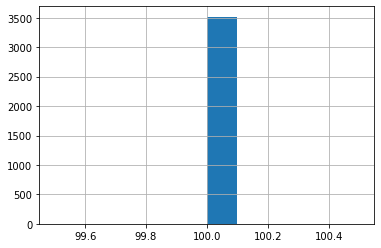

In [19]:
# check whether sum of percentages is indeed 100%

streetview_w_labels_df.apply(lambda x: sum_segmentation_data(x, viewpoints=["segmentation_agg"]), axis=1).hist()
streetview_w_labels_df.apply(lambda x: sum_segmentation_data(x, viewpoints=["segmentation_agg"]), axis=1)

# Pivoting: one column per landscape class

We want to have one column per landscape class.

In [20]:
landscape_percentages = streetview_w_labels_df.segmentation_agg.apply(pd.Series).fillna(0.0)
# filtering on classes which have way to few observations
landscape_percentages = landscape_percentages[
    landscape_percentages.sum(axis=0).index[landscape_percentages.sum(axis=0)>5]
]
landscape_percentages.head()

,wall,building,sky,tree,road,sidewalk,earth,plant,car,fence,...,trade,flag,boat,bed,armchair,cabinet,ship,painting,escalator,booth
0,0.921509,18.055481,35.353394,1.885071,27.309998,4.731689,0.191528,3.005127,5.669922,0.040222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.921509,18.055481,35.353394,1.885071,27.309998,4.731689,0.191528,3.005127,5.669922,0.040222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.362244,7.188843,25.282104,19.445923,20.160461,12.722107,0.049316,3.382507,0.198853,0.380981,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.362244,7.188843,25.282104,19.445923,20.160461,12.722107,0.049316,3.382507,0.198853,0.380981,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.063538,33.923218,20.401855,5.061157,29.308716,6.710693,0.097839,1.469055,1.652649,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
streetview_labeled_final_df = pd.concat(
    [
        streetview_w_labels_df[["coord", "pano_id"]], 
        landscape_percentages
    ], axis=1)

In [30]:
# add image links
for _heading, _suffix in zip(["north", "east", "south", "west"],suffixes):
    streetview_labeled_final_df[f"img_{_heading}"] = prefix+ streetview_labeled_final_df.pano_id + _suffix
    streetview_labeled_final_df[f"img_{_heading}_masked"] = prefix.replace("raw/google_streetview", "processed/google_streetview_masked") + streetview_labeled_final_df.pano_id + _suffix
streetview_labeled_final_df["lat"] = streetview_labeled_final_df.coord.apply(lambda x: x.split(",")[0]).astype(float)
streetview_labeled_final_df["long"] = streetview_labeled_final_df.coord.apply(lambda x: x.split(",")[1]).astype(float)
streetview_labeled_final_df = streetview_labeled_final_df.drop(columns="coord")
streetview_labeled_final_df

,pano_id,wall,building,sky,tree,road,sidewalk,earth,plant,car,...,img_north,img_north_masked,img_east,img_east_masked,img_south,img_south_masked,img_west,img_west_masked,lat,long
0,OlhTCaEsakPsBnnrQ33b1Q,0.921509,18.055481,35.353394,1.885071,27.309998,4.731689,0.191528,3.005127,5.669922,...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,50.940104,4.062487
1,OlhTCaEsakPsBnnrQ33b1Q,0.921509,18.055481,35.353394,1.885071,27.309998,4.731689,0.191528,3.005127,5.669922,...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,50.944063,4.028181
2,JNVwpgpEKp5AZIYKxZm9ew,0.362244,7.188843,25.282104,19.445923,20.160461,12.722107,0.049316,3.382507,0.198853,...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,51.084607,3.436877
3,JNVwpgpEKp5AZIYKxZm9ew,0.362244,7.188843,25.282104,19.445923,20.160461,12.722107,0.049316,3.382507,0.198853,...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,51.087108,3.458313
4,TFSmQVL_3EteK0mI2BNVdw,0.063538,33.923218,20.401855,5.061157,29.308716,6.710693,0.097839,1.469055,1.652649,...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,50.983138,4.828583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513,HdYh-DPxLrZhE0ujdkI-Ew,0.796143,12.002258,26.639832,15.582703,31.398682,4.271851,0.464172,2.283875,2.332642,...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,51.267956,4.651661
3514,c6XGTy6gp8FZVdYPG8CLNw,0.055420,3.479919,45.671570,2.080444,25.236267,0.159912,0.034363,1.983521,0.297546,...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,50.886564,3.842151
3

In [31]:
pickle.dump(streetview_labeled_final_df, open("../data/processed/20220302_streetview_coordinates_w_labels.pkl", "wb"))


### Top categories

Let's show the top categories in % of total coverage

In [24]:
segm_colums = [col for col in streetview_labeled_final_df.select_dtypes(include=[float]) if col not in ["lat", "long"]]
streetview_labeled_final_df[segm_colums].sum(axis=0).sort_values(ascending=False)[:15] *100 / streetview_labeled_final_df[segm_colums].sum().sum()

sky         26.110552
road        21.506947
building    21.502653
tree         9.159616
sidewalk     5.969129
grass        3.995531
car          3.557653
plant        3.160357
earth        1.017415
wall         0.774445
house        0.612352
fence        0.549575
floor        0.502428
field        0.338652
path         0.319430
dtype: float64

In [26]:
import pickle
streetview_labeled_final_df = pickle.load(open("../data/processed/20220302_streetview_coordinates_w_labels.pkl", "rb"))
streetview_labeled_final_df


,pano_id,wall,building,sky,tree,road,sidewalk,earth,plant,car,...,img_north,img_north_masked,img_east,img_east_masked,img_south,img_south_masked,img_west,img_west_masked,lat,long
0,OlhTCaEsakPsBnnrQ33b1Q,0.921509,18.055481,35.353394,1.885071,27.309998,4.731689,0.191528,3.005127,5.669922,...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,50.940098,4.062445
1,OlhTCaEsakPsBnnrQ33b1Q,0.921509,18.055481,35.353394,1.885071,27.309998,4.731689,0.191528,3.005127,5.669922,...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,../data/raw/google_streetview/OlhTCaEsakPsBnnr...,../data/processed/google_streetview_masked/Olh...,50.940098,4.062445
2,JNVwpgpEKp5AZIYKxZm9ew,0.362244,7.188843,25.282104,19.445923,20.160461,12.722107,0.049316,3.382507,0.198853,...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,51.084623,3.436899
3,JNVwpgpEKp5AZIYKxZm9ew,0.362244,7.188843,25.282104,19.445923,20.160461,12.722107,0.049316,3.382507,0.198853,...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,../data/raw/google_streetview/JNVwpgpEKp5AZIYK...,../data/processed/google_streetview_masked/JNV...,51.084623,3.436899
4,TFSmQVL_3EteK0mI2BNVdw,0.063538,33.923218,20.401855,5.061157,29.308716,6.710693,0.097839,1.469055,1.652649,...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,../data/raw/google_streetview/TFSmQVL_3EteK0mI...,../data/processed/google_streetview_masked/TFS...,50.983143,4.828602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513,HdYh-DPxLrZhE0ujdkI-Ew,0.796143,12.002258,26.639832,15.582703,31.398682,4.271851,0.464172,2.283875,2.332642,...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,../data/raw/google_streetview/HdYh-DPxLrZhE0uj...,../data/processed/google_streetview_masked/HdY...,51.265189,4.712420
3514,c6XGTy6gp8FZVdYPG8CLNw,0.055420,3.479919,45.671570,2.080444,25.236267,0.159912,0.034363,1.983521,0.297546,...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,../data/raw/google_streetview/c6XGTy6gp8FZVdYP...,../data/processed/google_streetview_masked/c6X...,50.886657,3.842236
3

In [31]:
segm_colums = [col for col in streetview_labeled_final_df.select_dtypes(include=[float]) if col not in ["lat", "long"]]
streetview_labeled_final_df[segm_colums].sum()
streetview_labeled_final_df[segm_colums].var()

wall           2.239901
building     323.562052
sky          121.223938
tree         110.201709
road          43.824404
                ...    
cabinet        0.000886
ship           0.012254
painting       0.019508
escalator      0.001289
booth          0.003103
Length: 62, dtype: float64